# Hipótesis 4

Como fue descrito con anterioridad, la tarjeta de datos empleada en la comprobación de la hipótesis contenía los datos referidos al producto interior bruto (PIB) de multitud de países, representando su evolución económica, y datos que reflejan las cantidades de vehículos eléctricos en dichas zonas. El intervalo final de tiempo que se estableció para llevar a cabo los análisis comienza en 2017 y termina en 2022. 

## Imports básicos

In [1]:
# 1. Imports básicos

import os
import sys
import sklearn
import warnings
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import cluster, stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


warnings.filterwarnings("ignore")
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()


## Carga de datos

In [2]:
# 2. Carga de datos

ruta_actual = os.getcwd()
directorio_superior = os.path.dirname(ruta_actual)
sys.path.append(directorio_superior)
from Acceso_BBDD.MetodosBBDD import *

os.chdir(directorio_superior)
dataframe = obtener_dataframe_sql('Hipotesis_4', GOLD)
dataframe = dataframe.set_index('Country')
dataframe.head()

,PIB_2017,PIB_2018,PIB_2019,PIB_2020,PIB_2021,PIB_2022,CochesVendidos_2017,CochesVendidos_2018,CochesVendidos_2019,CochesVendidos_2020,CochesVendidos_2021,CochesVendidos_2022
Country,,,,,,,,,,,,
Argentina,14618.327,11786.433,10054.023,8571.937,10631.665,13619.875,859770,772980,436794,324340,352514,378633
Australia,55804.163,56352.938,54289.066,53094.491,63841.724,64813.854,1122073,1076319,983031,832657,909983,918373
Austria,47320.537,51234.477,50195.321,48857.083,53528.707,52191.771,379184,370315,358175,274619,286070,226794
Belgium,44274.073,47685.347,46783.005,45545.233,51472.103,49843.163,578146,579262,584100,464683,416309,385225
Brazil,10419.576,9629.603,9364.237,7344.529,8165.637,9455.328,2169110,2475994,2679239,1963496,1982758,1971613


## Análisis de Correlación entre variables

Lo primero que se decidió fue revisar la correlación existente entre las variables (o columnas de la tarjeta de datos) con las que se trabajaría. Los resultados obtenidos denotaban una total relación entre las cifras económicas de PIB de los países, pues casi en todas las combinaciones de pares de ellas el coeficiente calculado era 1 o una cantidad muy cercana. Esto tiene sentido al pensar que rara vez el crecimiento o decrecimiento de una zona geográfica en términos monetarios sufre modificaciones aleatorias o repentinas de forma representativa. Por otro lado, en el caso de las variables enfocadas en ventas de vehículos eléctricos ocurría todo lo contrario (valores casi nulos), por lo que queda clara la ausencia de ningún tipo de tendencia social que afecte a este sector del mercado. 

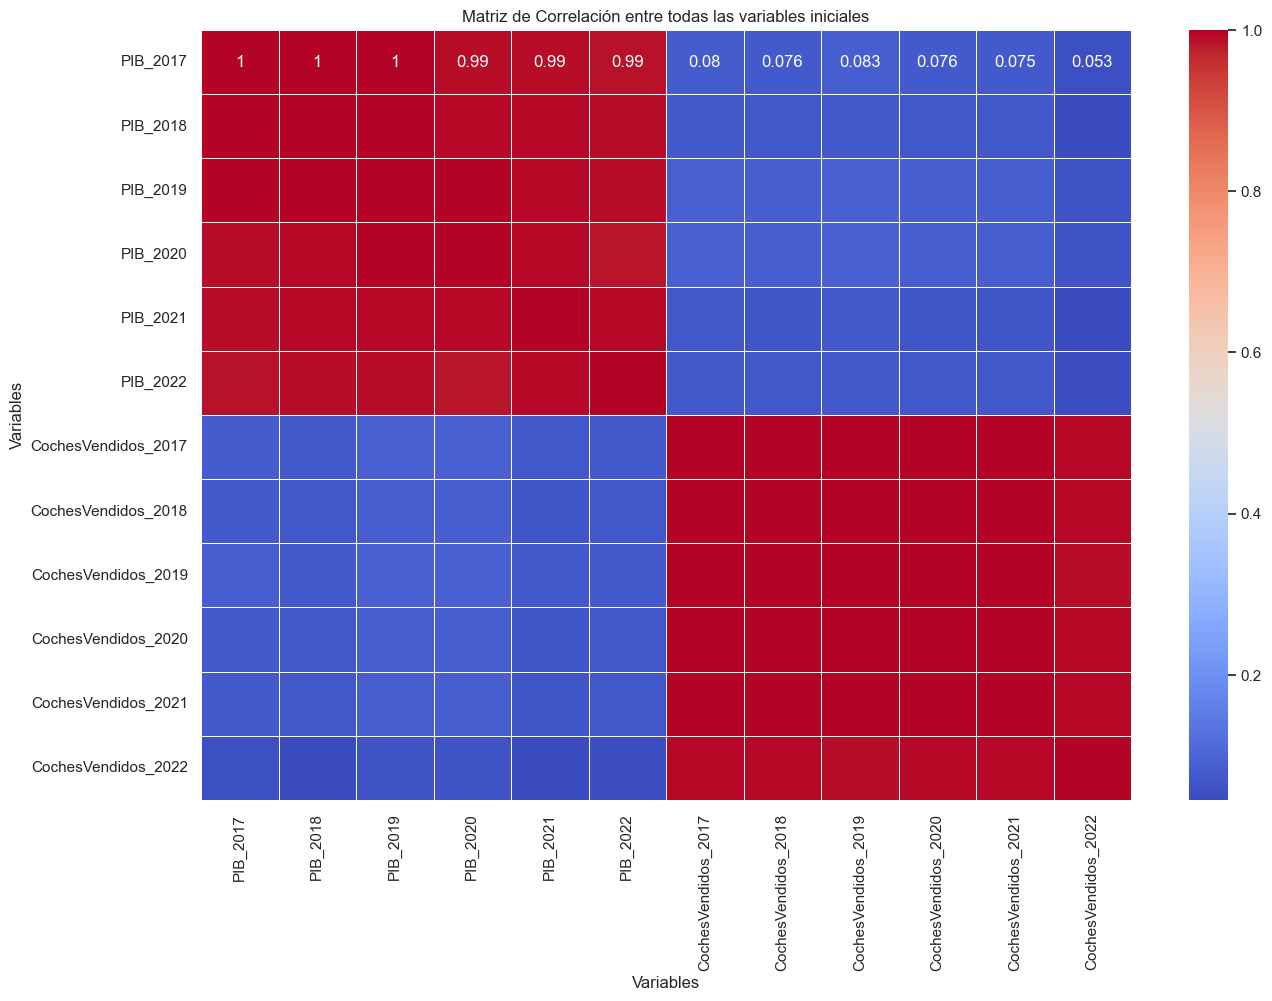

In [3]:
# 3. Análisis de Correlación entre variables

correlation_matrix = dataframe.corr()
sns.set(style="white")
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación entre todas las variables iniciales")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()


## Análisis de Componentes Principales

Luego, como aproximación a los pasos posteriores y para seguir recolectando información potencialmente útil sobre el conjunto de datos, se extrajo los componentes principales de ellos. Esta técnica busca la proyección según la cual los datos queden mejor representados en términos de mínimos cuadrados, de tal forma que es viable la reducción de dimensionalidad de los dataset mientras se ordenan las restantes según su importancia. En concreto fueron solamente dos el número de características con las que se trabajó, pues ellas podrían después ser graficadas de forma cómoda y sencilla. De esta manera se probó que ciertos países sobresalían del conjunto restante como es el caso de China, EEUU o Luxemburgo.

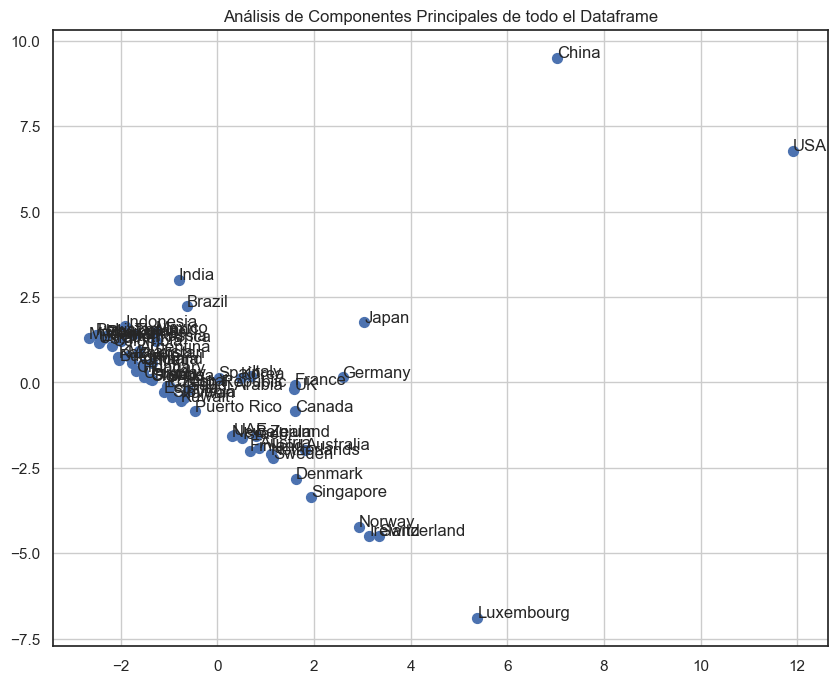

In [4]:
# 4. Análisis de Componentes Principales de todo el Dataframe

states = scaler.fit_transform(dataframe)
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(states)

plt.figure(figsize=(10, 8))
plt.title("Análisis de Componentes Principales de todo el Dataframe")
plt.scatter(X_pca[:,0], X_pca[:,1], s=50)
for i in range(len(X_pca)):
    plt.text(X_pca[i, 0], X_pca[i, 1], dataframe.iloc[i, :].name)
plt.grid()
plt.show()

Tras estos dos acercamientos, se tomó la decisión de que el uso de técnicas de clustering podría suponer un buen medio para resolver el problema y arrojar pruebas visuales que confirmaran o desmintieran que “Se venden más vehículos en países con más PIB per cápita”: se pensó en representar gráficamente separados por grupos (o clusters) los países estudiados tanto en el ámbito económico como de venta de coches eléctricos. Así resultaría evidente si el grupo de aquellos con mejor estadísticas monetarias contarían a su vez con las más altas tasas de adquisiciones de vehículos. 

Con ese objetivo en mente, se separó la tarjeta de datos en dos diferentes dataframes nuevamente, uno para el producto interior bruto y el otro para ventas de coches. Además, tuvo que llevar a cabo un proceso de normalización sobre ambos para evitar problemas derivados de órdenes de dimensión diferentes: fue elegido un MinMaxScaler, capaz de transformar a una escala con mínimo = 0 y máximo = 1. 

 

## Separación y normalización de datos sobre PIB

In [5]:
# 5. Separación y normalización de datos sobre PIB

df_PIB = dataframe[['PIB_2017','PIB_2018','PIB_2019','PIB_2020','PIB_2021','PIB_2022']]
datanorm_PIB = min_max_scaler.fit_transform(df_PIB)

## Separación y normalización de datos sobre Vehículos Vendidos

In [6]:
# 6. Separación y normalización de datos sobre Vehículos Vendidos

df_Coches_Vendidos = dataframe[['CochesVendidos_2017','CochesVendidos_2018','CochesVendidos_2019','CochesVendidos_2020','CochesVendidos_2021','CochesVendidos_2022']]
datanorm_Coches_Vendidos = min_max_scaler.fit_transform(df_Coches_Vendidos)


## Cálculo de las matrices de similitud

Posteriormente a este procesado y tras la documentación sobre modalidades de clustering vistas durante el curso, se pensó que sería de gran ayuda en el futuro contar tanto con los componentes principales de los dos dataframes generados como con la matriz de similitud. Al igual que antes, en el primer caso se extrajo sólo dos componentes y volvió a emplearse un StandardScaler debido a que al transformar los datos de manera que tengan una media de 0 y una desviación estándar de 1 se evita que ciertas características dominen sobre otras simplemente debido a sus unidades o magnitudes. En el segundo caso la construcción de dichas matrices surgió por la necesidad de comprobar cómo de parecidos eran entre sí los valores de las variables usadas (se utiliza distancia euclídea para ello) para más adelante confeccionar los cluster de manera exacta.  

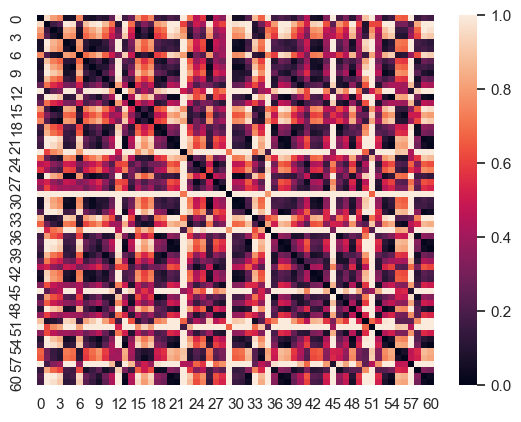

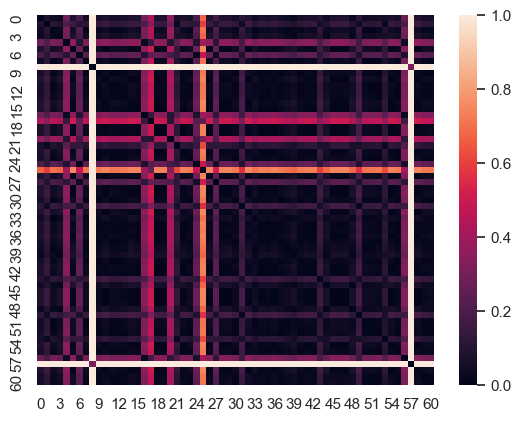

In [7]:
def calcular_matriz_similitud(datanorm, nombre_grafica):
    # 7. Obtención de Componentes Principales sobre el dataframe normalizado introducido y Similarity Matrix

    states_datanorm = scaler.fit_transform(datanorm)
    estimator = PCA (n_components = 2)
    pca_dataframe = estimator.fit_transform(states_datanorm)

    dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
    matsim = dist.pairwise(datanorm)
    ax = sns.heatmap(matsim,vmin=0, vmax=1)
    plt.show()

    return matsim, pca_dataframe


matsim_pib, PIB_pca = calcular_matriz_similitud(datanorm_PIB, "matriz_similitud_PIB")
matsim_coches_vendidos, Coches_Vendidos_pca  = calcular_matriz_similitud(datanorm_Coches_Vendidos, "matriz_similitud_Vehiculos_Vendidos")


Como información adicional que apoya la teoría propuesta al analizar las correlaciones de las variables, la matriz de similitud de los datos sobre PIB contiene tonos mucho más claros que los oscuros expuestos en la matriz referida a vehículos, lo que denota mayor relación o parecido. 

## Implementación de una forma de representar los clusters

Con el fin de contrastar diferentes enfoques proporcionados por las técnicas de clustering estudiadas durante el curso decidió implementarse tres de ellas. De esa forma se vio la posibilidad de obtener el mismo resultado (mejor opción posible pues quedaría la hipótesis podría aceptarse o rechazarse directamente) o al menos seleccionar el más lógico y cercano a la realidad. 

 

Todos esos enfoques coincidieron en declarar como cantidad óptima de clusters o clases el 2. Esto abrió la puerta a dividir los países estudiados en únicamente dos extremos: aquellos con más o menos poder adquisitivo (para clusters generados a partir del dataset sobre el PIB); y aquellos punteros o no en compras de vehículos eléctricos (para clusters generados a partir del dataset restante). Esto facilitó las futuras interpretaciones, pues desde ese momento bastaba con observar si en las agrupaciones creadas de países los que estaban en un extremo para un dataset lo estaban también en el otro (más ricos junto con más compras de coches y viceversa). 

 

Es digno de mención que se empleó como métrica de evaluación de clusters el coeficiente de Silhouette, que posee un rango de -1 a 1, representando valores cercanos a este último que los objetos (países en este caso) están bien ajustados a su propio cluster y, al mismo tiempo, están separados de otros clusters. 

In [8]:
def representar_clusters(dataframe, labels, num_inicial_labels, pca_dataframe, nombre_grafica):
    # 8. Algoritmo para representar los cluster generados

    colores = []
    for label in labels:
        if label == num_inicial_labels:
            colores.append("blue")
        else:
            colores.append("green")

    plt.figure(figsize=(10, 8))
    plt.title(nombre_grafica)
    plt.scatter(pca_dataframe[:,0], pca_dataframe[:,1], c=colores,s=50)

    for i in range(len(labels)):
        if labels[i] != num_inicial_labels:
            plt.text(pca_dataframe[i, 0], pca_dataframe[i, 1], dataframe.iloc[i, :].name)

    plt.grid()
    plt.show()

## Clustering Jerárquico

Se comenzó por este tipo de clustering. Para el dataset sobre PIB arrojó dos agrupaciones o clusters con un coeficiente de Silhouette de 0’656, mientras que para el de Vehículos Vendidos un valor de 0’934.

In [9]:
def clustering_jerarquico(dataframe, datanorm, matsim, pca_dataframe, nombre_grafica):
    # 9. Clustering Jerárquico sobre el PIB o los Vehiculos Vendidos

    best_silhouette = -1
    best_cut = -1
    best_method = ""

    # Prueba diferentes valores de cut y métodos de enlace
    for cut_value in range(1,  6):  # Prueba diferentes valores de cut
        for method in ['single', 'complete', 'average', 'ward']:  # Prueba diferentes métodos de enlace
            clusters = cluster.hierarchy.linkage(matsim, method=method)
            labels = cluster.hierarchy.fcluster(clusters, cut_value, criterion='distance')
            silhouette = metrics.silhouette_score(datanorm, labels)

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_cut = cut_value
                best_method = method

    print('Best cut value: %d' % best_cut)
    print('Best linkage method: %s' % best_method)
    print('Best Silhouette Coefficient: %0.3f' % best_silhouette)

    clusters = cluster.hierarchy.linkage(matsim, method=best_method)
    labels = cluster.hierarchy.fcluster(clusters, best_cut , criterion = 'distance')

    representar_clusters(dataframe, labels, min(labels), pca_dataframe, nombre_grafica)


### Clustering Jerárquico sobre PIB

Best cut value: 3
Best linkage method: single
Best Silhouette Coefficient: 0.656


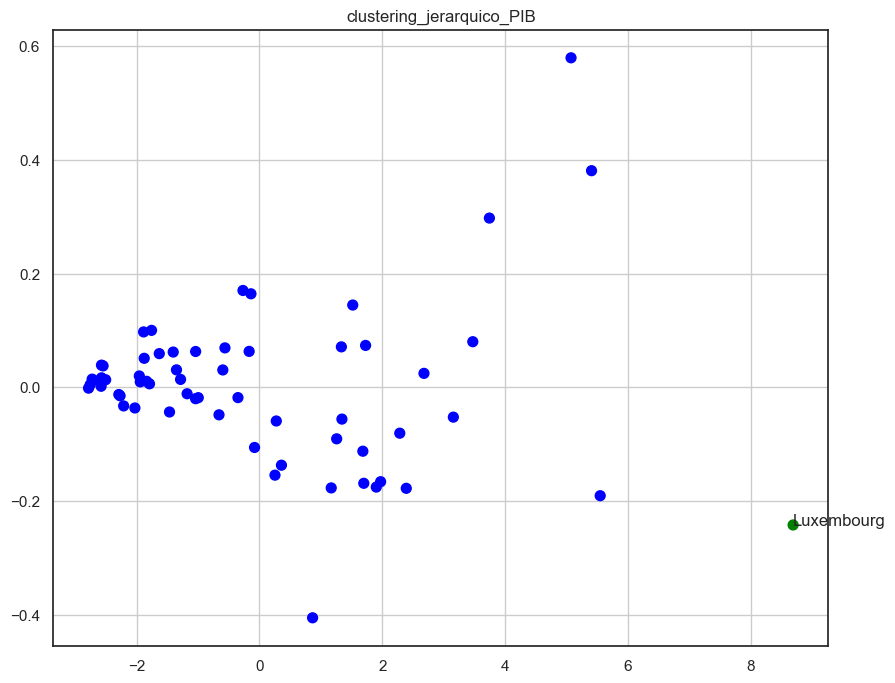

In [10]:
clustering_jerarquico(df_PIB, datanorm_PIB, matsim_pib, PIB_pca, "clustering_jerarquico_PIB")

### Clustering Jerárquico sobre Vehículos Vendidos

Best cut value: 3
Best linkage method: single
Best Silhouette Coefficient: 0.934


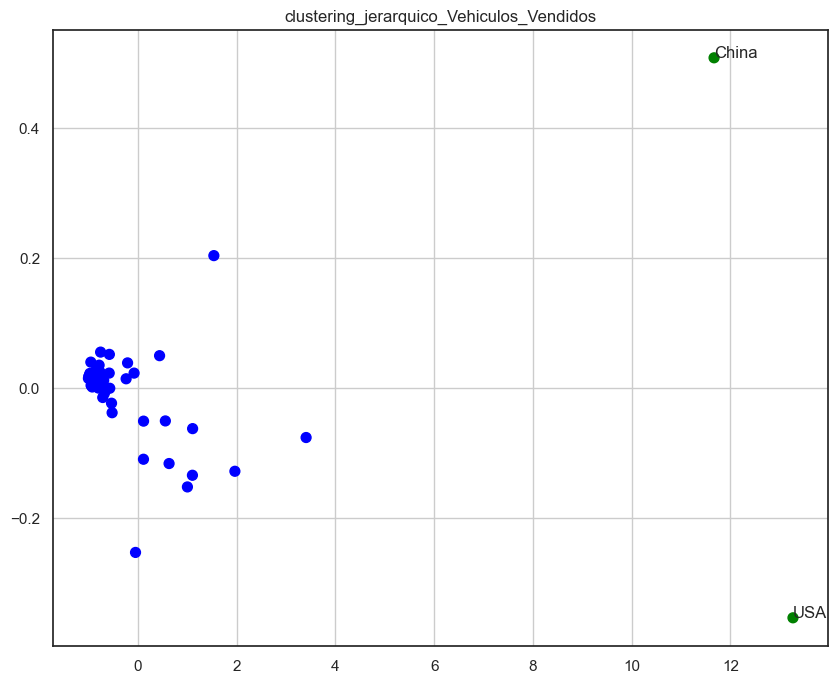

In [11]:
clustering_jerarquico(df_Coches_Vendidos, datanorm_Coches_Vendidos, matsim_coches_vendidos, Coches_Vendidos_pca, "clustering_jerarquico_Vehiculos_Vendidos")

En términos económicos, es curioso cómo se clasifican los países: únicamente se introduce dentro del grupo de los que mejores datos de producto interior bruto a Luxemburgo. Mientras tanto, en términos de adquisiciones de vehículos eléctricos destacan por encima del resto China y EEUU, algo más esperable. 

## Clustering K-Means

Para el dataset sobre PIB arrojó dos agrupaciones o clusters con un coeficiente de Silhouette de 0’638 (ligeramente menor que antes), mientras que para el de Vehículos Vendidos un valor de 0’934 (exactamente igual que antes). Ambos resultados volvieron a ser bastante prometedores.

In [12]:
def clustering_k_means(dataframe, pca_dataframe, nombre_grafica):
    # 10. Clustering K-Means sobre el PIB o los Vehiculos Vendidos

    n_clusters_values = range(2, 7)
    init_values = ['k-means++', 'random']

    best_silhouette = -1
    best_params = {}

    for n_clusters in n_clusters_values:
        for init_method in init_values:
            km = KMeans(n_clusters=n_clusters, init=init_method, n_init=10, max_iter=300, tol=0.0001, random_state=42)
            labels = km.fit_predict(PIB_pca)
            silhouette = metrics.silhouette_score(pca_dataframe, labels)

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params = {'n_clusters': n_clusters, 'init': init_method}

    print('Best combination of parameters:')
    print(best_params)
    print('Best Silhouette Coefficient: %0.3f' % best_silhouette)

    km = KMeans(n_clusters=best_params['n_clusters'], init=best_params['init'], n_init=10, max_iter=300, tol=0.0001, random_state=42)
    y_km = km.fit_predict(pca_dataframe)

    #AD-HOC !!! (para que el cluster de la derecha sea el verde como en el caso del clustering jerárquico)
    lista_invertida = []
    if nombre_grafica == "clustering_k_means_PIB":
        lista_invertida = [1 if valor == 0 else 0 for valor in km.labels_]
        representar_clusters(dataframe, lista_invertida, min(lista_invertida), pca_dataframe, nombre_grafica)
    else:
        representar_clusters(dataframe, km.labels_, min(km.labels_), pca_dataframe, nombre_grafica)


### Clustering K-Means sobre PIB

Best combination of parameters:
{'n_clusters': 2, 'init': 'k-means++'}
Best Silhouette Coefficient: 0.642


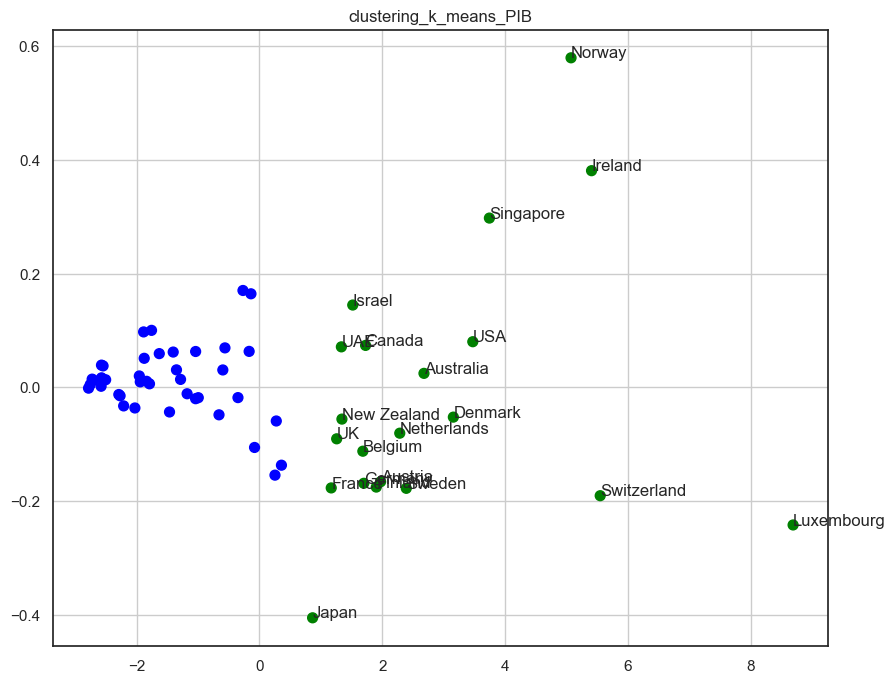

In [13]:
clustering_k_means(df_PIB, PIB_pca, "clustering_k_means_PIB")

### Clustering K-Means sobre Vehículos Vendidos

Best combination of parameters:
{'n_clusters': 2, 'init': 'k-means++'}
Best Silhouette Coefficient: 0.136


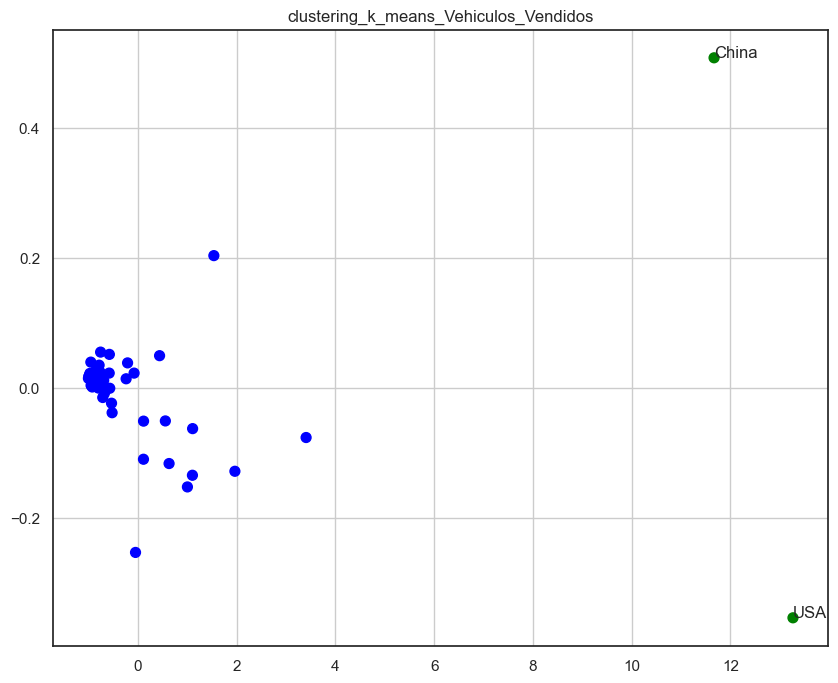

In [14]:
clustering_k_means(df_Coches_Vendidos, Coches_Vendidos_pca, "clustering_k_means_Vehiculos_Vendidos")

En términos económicos, esta vez se sitúa a un número más equilibrado de países en cada uno de los dos grandes grupos, algo que es más realista que el caso anterior. Mientras tanto, en términos de adquisiciones de vehículos eléctricos destacan por encima del resto China y EEUU, es decir, lo mismo que ocurría antes y lo que significa que esta clasificación es bastante confiable. 

 

## Clustering Probabilístico

Para acabar con el análisis se tomó la decisión de emplear un tercer tipo de clustering, a pesar de ya contar con resultados ciertamente determinantes. A la hora de utilizar esta técnica apareció un problema, y es que al basarse en probabilidad (la aleatoriedad se establece desde el momento mismo de creación de la clase que genera los clusters), los resultados que ofrece pueden variar de una ejecución a otra del código. Esto es lo que ocurre de manera frecuente con las clasificaciones llevadas a cabo sobre el dataset de vehículos vendidos (no en el del PIB, que se mantuvo estable, al menos).  

 

En adición, en este caso no puede presentarse como argumento de fiabilidad el coeficiente de Silhouette debido a que ni es utilizado: simplemente se maneja el “bic” (Bayesian Information Criterion). Este criterio compara el ajuste de diferentes modelos, pero penalizando la complejidad del modelo (número de parámetros), de modo que el modelo con menor valor de BIC debe elegirse. 

In [15]:
def clustering_probabilistico(dataframe, pca_dataframe, nombre_grafica):
    # 11. Clustering Probabilístico sobre el PIB o los Vehiculos Vendidos

    lowest_bic = np.infty
    bic = []
    best_cv = ''
    best_k = -1

    cv_types = ['spherical', 'tied', 'diag', 'full']

    for cv_type in cv_types:
        for k in range(1, 3):
            gmm = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='kmeans')
            gmm.fit(pca_dataframe)
            bic.append(gmm.bic(pca_dataframe))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_cv = cv_type
                best_k = k

    print ("Mejor valor K", best_k, "Mejor tipo de Covarianza", best_cv)

    gmm = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
    gmm.fit(pca_dataframe)
    labels =  gmm.predict(pca_dataframe)

    #AD-HOC !!! (para que el cluster de la derecha sea el verde como en el caso del clustering jerárquico)
    df_aux = dataframe.copy()
    df_aux = df_aux.reset_index()
    df_aux["group"] = labels
    indice = df_aux.index[df_aux['Country'] == 'Argentina']
    grupo = labels[indice]

    lista_invertida = []
    if nombre_grafica == "clustering_probabilistico_PIB" and grupo != 0 or nombre_grafica == "clustering_probabilistico_Vehiculos_Vendidos" and grupo != 1:
        lista_invertida = [1 if valor == 0 else 0 for valor in labels]
        representar_clusters(dataframe, lista_invertida, min(lista_invertida), pca_dataframe, nombre_grafica)
    else:
        representar_clusters(dataframe, labels, min(labels), pca_dataframe, nombre_grafica)


### Clustering Probabilístico sobre PIB

Mejor valor K 2 Mejor tipo de Covarianza diag


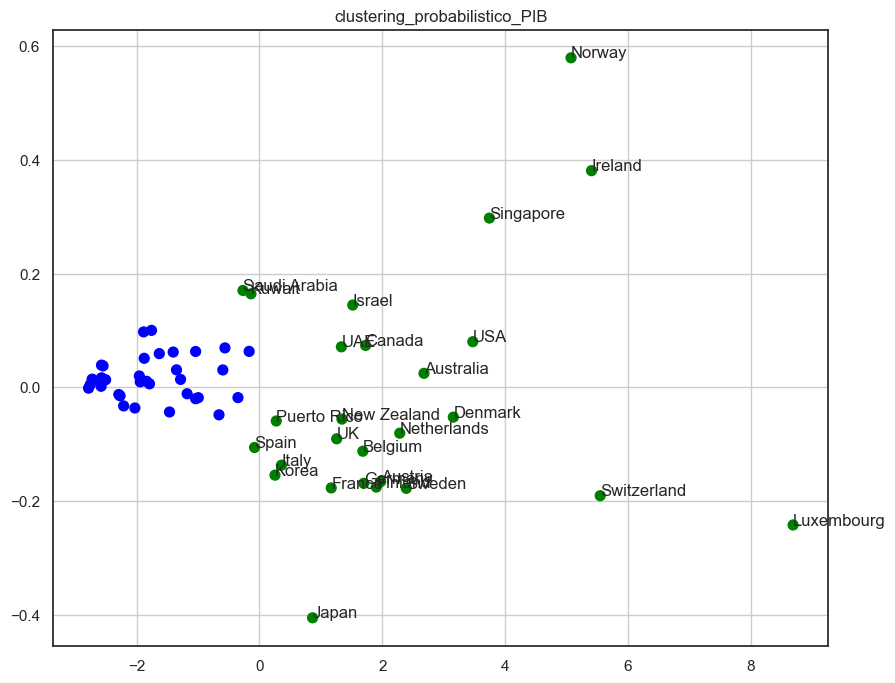

In [16]:
clustering_probabilistico(df_PIB, PIB_pca, "clustering_probabilistico_PIB")

### Clustering Probabilístico sobre Vehículos Vendidos

Mejor valor K 2 Mejor tipo de Covarianza full


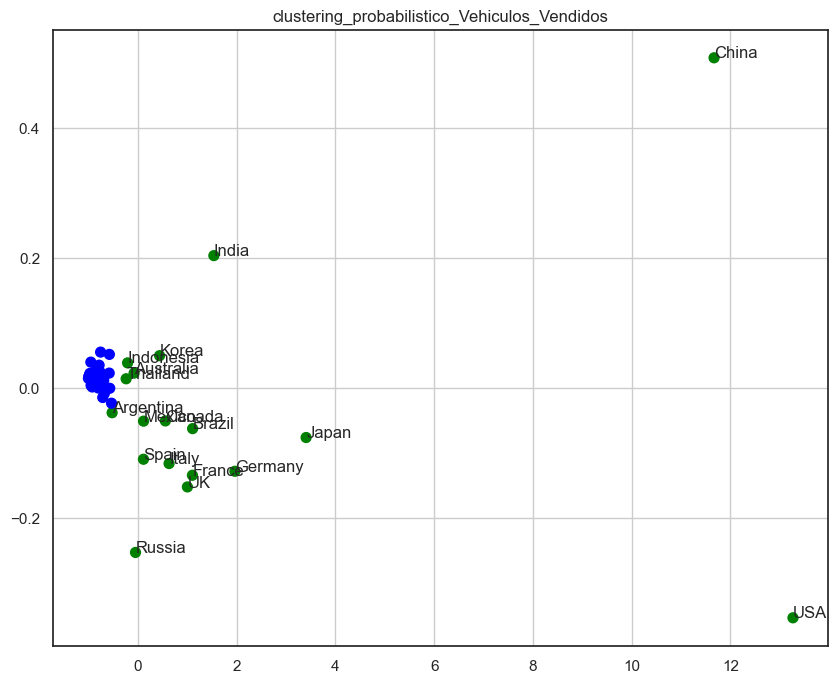

In [17]:
clustering_probabilistico(df_Coches_Vendidos, Coches_Vendidos_pca, "clustering_probabilistico_Vehiculos_Vendidos")

## Conclusión sobre el clustering

Posteriormente al estudio de las tres posibilidades presentadas más arriba, se consideró que la más acorde con lo que realmente sucedió es la ofrecida por el Clustering K-Means. No obstante, ni en esa solución ni en las demás hubo una clara relación entre los países clasificados como económicamente sobresalientes y aquellos destacados en ventas de vehículos no contaminantes, por lo que se llegó a la conclusión de que la hipótesis que venía intentándose contrastar debía rechazarse (a pesar de que inicialmente era lógico pensar que sería cierta).  

 

El conocimiento oculto que se desprende de todo lo comentado sobre la hipótesis es que aquellas potencias mundiales con mejores indicadores monetarios son partidarios de realizar inversiones en otros campos diferentes de la automoción eléctrica y sostenible. 

## Contraste de hipótesis adicional

Al poco tiempo de acabar el estudio realizado sobre la tarjeta de datos, se pensó en añadir una última comprobación. Echando un vistazo rápido sobre los datos referidos a la cantidad de coches que no usan la combustión a lo largo de los años manejados, surgieron algunas dudas sobre si realmente con el paso del tiempo había aparecido un incremento en las ventas de ellos o más bien todo lo contrario. 

En concreto, se lanzó la hipótesis de que las ventas de vehículos eléctricos del año 2019 superaron a las de 2022. A partir de dicho momento, se trabajó para verificar si dicha afirmación era fruto de la mera casualidad (H0) o detrás existían razones de peso que tuvieran como consecuencia ese resultado (H1). 

### Contraste de hipótesis usando muestreo bootstraping

In [18]:
def meanBootstrap(dataframe, num_datos):
  muestra = [0] * num_datos
  for i in range(num_datos):
    sample = [dataframe[j] for j in np.random.randint(len(dataframe), size=len(dataframe))]
    muestra[i] = np.mean(sample)
  return muestra

def intervalo_confianza_bootstrap(dataframe, columna_1, columna_2):
    # 14. Contraste de hipótesis con muestreo bootstraping

    sample_1 = meanBootstrap(dataframe[columna_1], 200)
    mean_1 = np.mean(sample_1)
    se_1 = np.std(sample_1)

    sample_2 = meanBootstrap(dataframe[columna_2], 200)
    mean_2 = np.mean(sample_2)
    se_2 = np.std(sample_2)

    print("--- INTERVALOS DE CONFIANZA CON BOOTSTRAP ---\n")
    print (f"Media de {columna_1}: {mean_1:6.2f}")
    print(f"Desviación típica de {columna_1}: {se_1:.2f}\n")
    print (f"Media de {columna_2}: {mean_2:6.2f}")
    print(f"Desviación típica de {columna_2}: {se_2:.2f}\n")

    print (f"Intervalo de confianza para {columna_1}: ",[mean_1 - se_1*1.96/ np.sqrt(len(sample_1)), 
                            mean_1 + se_1*1.96/ np.sqrt(len(sample_1))])
    print (f"Intervalo de confianza para {columna_2}: ",[mean_2 - se_1*1.96/ np.sqrt(len(sample_1)), 
                            mean_2 + se_2*1.96/ np.sqrt(len(sample_2))],"\n")
     

La primera idea que se tuvo fue evitar el uso del muestreo, dado que éste es recomendable para casos en los que se tenga una cantidad tan ingente de datos que suponga un verdadero reto su manejo, algo que para nada ocurría en nuestro dataset (no obstante, se probó de igual forma esa técnica sobre él, confirmando las sospechas de su mejorable funcionamiento).  

In [19]:
intervalo_confianza_bootstrap(dataframe, "CochesVendidos_2019", "CochesVendidos_2022")

--- INTERVALOS DE CONFIANZA CON BOOTSTRAP ---

Media de CochesVendidos_2019: 1135797.96
Desviación típica de CochesVendidos_2019: 352392.68

Media de CochesVendidos_2022: 939838.16
Desviación típica de CochesVendidos_2022: 300509.58

Intervalo de confianza para CochesVendidos_2019:  [1086958.8299920298, 1184637.096893216]
Intervalo de confianza para CochesVendidos_2022:  [890999.027778915, 981486.6634748866] 



### Contraste de hipótesis sin muestreo

In [20]:
def intervalos_confianza_columna_completa(dataframe, columna_1, columna_2):
    # 13. Contraste de hipótesis sin muestreo

    datos_1 = dataframe[columna_1]
    datos_2 = dataframe[columna_2]
    print("\n--- CONTRASTE DE HIPÓTESIS SIN BOOTSTRAP ---\n")
    print (f"Media de {columna_1}: {datos_1.mean():6.2f}")
    print(f"Desviación típica de {columna_1}: {datos_1.std():.2f}\n")
    print (f"Media de {columna_2}: {datos_2.mean():6.2f}")
    print(f"Desviación típica de {columna_2}: {datos_2.std():.2f}\n")

    print (f"Intervalo de confianza para {columna_1}: ",[datos_1.mean() - datos_1.std()*1.96/ np.sqrt(len(datos_1)),
                            datos_1.mean() + datos_1.std()*1.96/ np.sqrt(len(datos_1))])
    print (f"Intervalo de confianza para {columna_2}: ",[datos_2.mean() - datos_2.std()*1.96/ np.sqrt(len(datos_2)),
                            datos_2.mean() + datos_2.std()*1.96/ np.sqrt(len(datos_2))],"\n")

    print(stats.ttest_ind(datos_1, datos_2, equal_var = False), "\n\n")



Finalmente, y con un grado de garantía del 95%, ciertas conclusiones fueron extraídas. A pesar de que la media de coches vendidos en 2019 sea mayor que la de 2022, la de ambos se sitúa en una zona central del intervalo de confianza del otro. Además, dichos intervalos son bastante similares, de manera que casi podría realizarse una perfecta superposición.  

 

El estudio terminó tras la ejecución de la prueba “T de Student” (manejamos dos años diferentes y sus varianzas son distintas) a través del método ttest_ind() proporcionado por Scipy. El p-value obtenido es muy alto como para considerar lo ocurrido estadísticamente significativo, así que al ser improbable que no haya sucedido por casualidad, se rechaza la hipótesis alternativa formulada inicialmente como H1 y se acepta la nula (H0). 

In [21]:
intervalos_confianza_columna_completa(dataframe, "CochesVendidos_2019", "CochesVendidos_2022")


--- CONTRASTE DE HIPÓTESIS SIN BOOTSTRAP ---

Media de CochesVendidos_2019: 1137015.08
Desviación típica de CochesVendidos_2019: 2687430.56

Media de CochesVendidos_2022: 949283.93
Desviación típica de CochesVendidos_2022: 2372786.12

Intervalo de confianza para CochesVendidos_2019:  [462598.2426135732, 1811431.9213208533]
Intervalo de confianza para CochesVendidos_2022:  [353827.8357554013, 1544740.0330970578] 

TtestResult(statistic=0.4089867008441667, pvalue=0.6832896051346736, df=118.18625160222523) 


